# CATBoost Model Preparation


In [ ]:
#!conda install catboost -y

In [72]:
spark.stop()

In [73]:
# Setup Environment
import os
import logging
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import set_config
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
import pyspark.sql.functions as F
import xgboost as xgb
from sklearn import set_config
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
import configparser
from pyspark.sql import SparkSession
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Window
from src.data_preprocessing.data_prep1.data_utils import (save_parquet, gather_statistics, 
                initialize_environment, load_config, initialize_spark, 
                identify_and_impute_outliers, 
                identify_and_remove_outliers, identify_missing_and_outliers)
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

In [74]:

spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()


Spark session created successfully.


In [75]:
# This dataset has already been cleaned up in the LGB notebook and saved as a starting point
# It now just need to be converted to Panadas and run in the GBDT variant model (LGB, XGB, CatBoost)
race_df = spark.read.parquet(os.path.join(parquet_dir, "race_df_p2.parquet"))



In [57]:
race_df.count()

324041

# Switching to Pandas

In [58]:
race_df = race_df.toPandas()
# Quick info about the DataFrame
#print(df.info())
#print(df.head(5))

# Set race_id

In [59]:
race_df["race_id"] = (
    race_df["course_cd"].astype(str) + "_" +
    race_df["race_date"].astype(str) + "_" +
    race_df["race_number"].astype(str)
)


# Set Rank/Label

In [60]:
# If the largest official_fin is 20 (some races can have 20 horses),
# then label = (21 - official_fin).
# So official_fin=1 => label=20, official_fin=2 =>19, etc.
# If your max is 14, you can do (15 - official_fin).  Just ensure "best" horse has largest label.
race_df["rank"] = 21 - race_df["official_fin"]

In [61]:
if "official_fin" in race_df.columns:
    race_df.drop(columns=["official_fin"], inplace=True)

In [62]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["course_cd", "sex", "equip", "surface", "trk_cond", "weather", "med", 
            "race_type", "stk_clm_md", "turf_mud_mark", "layoff_cat"]
for c in cat_cols:
    lbl = LabelEncoder()
    race_df[c] = lbl.fit_transform(race_df[c].astype(str))

# Set race_id

In [63]:
race_df = race_df.sort_values("race_id", ascending=True)

# Check Distribution of Horses Per Race

count    41886.000000
mean         7.736260
std          1.956526
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         20.000000
dtype: float64
1        2
2       24
3      137
4      814
5     3443
6     7834
7     8913
8     7305
9     5206
10    4035
11    2178
12    1879
13      73
14      40
17       1
18       1
20       1
Name: count, dtype: int64


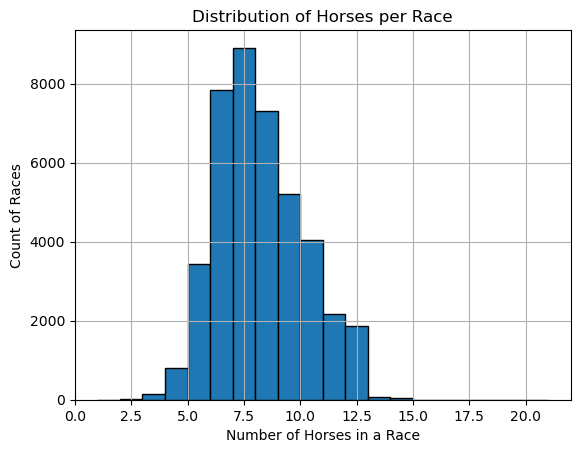

In [68]:
# 1) Count how many horses per race
counts_per_race = race_df.groupby("race_id").size()

# 2) Basic descriptive stats (mean, std, min, max, quartiles)
print(counts_per_race.describe())

# 3) Frequency table of the counts themselves (e.g., how many races had X horses)
print(counts_per_race.value_counts().sort_index())

# 4) Optional: visualize the distribution as a histogram
import matplotlib.pyplot as plt

counts_per_race.hist(bins=range(1, counts_per_race.max() + 2), edgecolor='black')
plt.xlabel("Number of Horses in a Race")
plt.ylabel("Count of Races")
plt.title("Distribution of Horses per Race")
plt.show()

# Set Features

In [64]:
features = [
    # Basic numeric columns
    "purse",
    "wps_pool",
    "weight",
    "claimprice",
    "power",
    "morn_odds",
    "distance_meters",
    "avgspd",
    "class_rating",
    "todays_cls",
    "net_sentiment",
    "avg_spd_sd",
    "ave_cl_sd",
    "hi_spd_sd",
    "pstyerl",

    # Cumulative performance stats
    "all_starts",
    "all_win",
    "all_place",
    "all_show",
    "all_fourth",
    "all_earnings",
    "cond_starts",
    "cond_win",
    "cond_place",
    "cond_show",
    "cond_fourth",
    "cond_earnings",

    # Recent form metrics
    "avg_fin_3",
    "avg_beaten_3",
    "avg_speed_3",
    "avg_fin_5",
    "avg_beaten_5",
    "avg_speed_5",
    "speed_improvement",
    "days_off",

    # Sectionals / GPS
    "avgtime_gate1",
    "avgtime_gate2",
    "avgtime_gate3",
    "avgtime_gate4",
    "total_distance_ran",
    "running_time",
    "speed_q1",
    "speed_q2",
    "speed_q3",
    "speed_q4",
    "total_dist_covered",
    "avg_acceleration",
    "net_progress_gain",
    "gps_avg_stride_length",

    # Jockey/Trainer stats
    "jock_win_percent",
    "jock_itm_percent",
    "trainer_win_percent",
    "trainer_itm_percent",
    "jt_win_percent",
    "jt_itm_percent",
    "jock_win_track",
    "jock_itm_track",
    "trainer_win_track",
    "trainer_itm_track",
    "jt_win_track",
    "jt_itm_track",

    # Other
    "age_at_race_day",
    "is_first_race",
]


X_all = race_df[features].values
y_all = race_df['rank'].values
race_ids = race_df['race_id'].values

# Extract X, y, race_id

In [65]:
X_all = race_df[features].values
y_all = race_df["rank"].values
race_ids = race_df["race_id"].values

# Split Data

In [66]:
from sklearn.utils import shuffle

unique_races = race_df["race_id"].unique()
unique_races = shuffle(unique_races, random_state=42)

train_ratio = 0.8
cut = int(len(unique_races) * train_ratio)
train_races = set(unique_races[:cut])
valid_races = set(unique_races[cut:])

train_mask = race_df["race_id"].isin(train_races)
valid_mask = race_df["race_id"].isin(valid_races)

X_train = X_all[train_mask]
y_train = y_all[train_mask]
race_id_train = race_ids[train_mask]

X_valid = X_all[valid_mask]
y_valid = y_all[valid_mask]
race_id_valid = race_ids[valid_mask]

# Convert race_id → integer group_id for CatBoost

In [67]:
import numpy as np

def make_group_id(race_id_array):
    # 1) Gather all unique race_id, sorted or not
    unique_r = sorted(set(race_id_array))
    # 2) Map each unique ID → integer
    race_to_gid = {r: i for i, r in enumerate(unique_r)}
    # 3) Build the group_id array for each row
    group_ids = np.array([race_to_gid[r] for r in race_id_array], dtype=int)
    return group_ids

train_gid = make_group_id(race_id_train)
valid_gid = make_group_id(race_id_valid)

# CATBoost

### Build CatBoost Pool objects (with group_id=...)

In [26]:
from catboost import Pool

# 1) Build your Pool objects with group_id
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=train_gid,  # an integer group ID per row
    # cat_features=cat_cols_indices if you have any
)
valid_pool = Pool(
    data=X_valid,
    label=y_valid,
    group_id=valid_gid,
    # cat_features=cat_cols_indices
)

### Define Param Grid

In [38]:
param_grid = {
    "iterations": [300, 500],
    "depth": [6, 8],
    "learning_rate": [0.01, 0.05],
    "l2_leaf_reg": [3, 5],
}

In [39]:
#!pip list catboost

In [47]:
from catboost import CatBoostRanker, Pool

best_score = float("-inf")
best_params = None
best_model = None

for iters in param_grid["iterations"]:
    for depth in param_grid["depth"]:
        for lr in param_grid["learning_rate"]:
            for l2_reg in param_grid["l2_leaf_reg"]:

                # Build trial_params
                trial_params = {
                    "loss_function": "QueryRMSE",   # GPU-friendly ranking objective
                    "eval_metric":   "QueryRMSE",   # the main evaluation is also QueryRMSE
                    "custom_metric": ["NDCG:top=5"], # so we can see NDCG@5 in logs/dict
                    "task_type":     "GPU",         # run training on GPU
                    "devices":       "0",           # or "0-1" for multiple GPUs
                    "iterations":    iters,
                    "depth":         depth,
                    "learning_rate": lr,
                    "l2_leaf_reg":   l2_reg,
                    "random_seed":   42,
                    "verbose":       50
                }

                model = CatBoostRanker(**trial_params)
                model.fit(
                    train_pool,
                    eval_set=[valid_pool],   # single validation set in a list
                    early_stopping_rounds=50,
                    use_best_model=True
                )

                # The dictionary typically looks like:
                # {
                #   'learn': {
                #       'QueryRMSE': 1.23,
                #       'NDCG:top=5;type=Base': 0.98  (if custom_metric was logged on training too)
                #   },
                #   'validation': {
                #       'QueryRMSE': 1.25,
                #       'NDCG:top=5;type=Base': 0.99
                #   }
                # }
                scores_dict = model.get_best_score()
                print("Scores dictionary:", scores_dict)

                # 1) CatBoost uses "validation" key, not "validation_0"
                # 2) The custom NDCG metric is labeled as "NDCG:top=5;type=Base"
                val_score = None
                if "validation" in scores_dict:
                    if "NDCG:top=5;type=Base" in scores_dict["validation"]:
                        val_score = scores_dict["validation"]["NDCG:top=5;type=Base"]
                        print(f"Validation NDCG@5: {val_score:.6f}")
                    else:
                        print("WARNING: 'NDCG:top=5;type=Base' not found in 'validation':", scores_dict["validation"])
                else:
                    print("WARNING: 'validation' key not found in get_best_score() =>", scores_dict)

                if val_score is not None:
                    print(f"Params={trial_params}")
                    print(f"Validation NDCG@5= {val_score:.6f}")

                    # Compare & possibly update the global best
                    if val_score > best_score:
                        best_score  = val_score
                        best_params = trial_params
                        best_model  = model
                else:
                    print("WARNING: Could not retrieve NDCG@5 metric. Full dict:", scores_dict)

print("Best Validation NDCG@5:", best_score)
print("Best Params:", best_params)

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4235262	test: 2.4260599	best: 2.4260599 (0)	total: 6.04ms	remaining: 1.8s
50:	learn: 2.1118011	test: 2.1166272	best: 2.1166272 (50)	total: 152ms	remaining: 740ms
100:	learn: 1.9218710	test: 1.9283758	best: 1.9283758 (100)	total: 295ms	remaining: 581ms
150:	learn: 1.8005622	test: 1.8078247	best: 1.8078247 (150)	total: 430ms	remaining: 424ms
200:	learn: 1.7181411	test: 1.7255795	best: 1.7255795 (200)	total: 562ms	remaining: 277ms
250:	learn: 1.6573590	test: 1.6647120	best: 1.6647120 (250)	total: 693ms	remaining: 135ms
299:	learn: 1.6099227	test: 1.6167601	best: 1.6167601 (299)	total: 822ms	remaining: 0us
bestTest = 1.616760055
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.6099226923319696}, 'validation': {'NDCG:top=5;type=Base': 0.9777671781210945, 'QueryRMSE': 1.6167600549484034}}
Validation NDCG@5: 0.977767
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 3

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4235279	test: 2.4260616	best: 2.4260616 (0)	total: 5.89ms	remaining: 1.76s
50:	learn: 2.1118685	test: 2.1166940	best: 2.1166940 (50)	total: 148ms	remaining: 725ms
100:	learn: 1.9219639	test: 1.9284680	best: 1.9284680 (100)	total: 284ms	remaining: 559ms
150:	learn: 1.8006013	test: 1.8078408	best: 1.8078408 (150)	total: 418ms	remaining: 413ms
200:	learn: 1.7183320	test: 1.7257657	best: 1.7257657 (200)	total: 552ms	remaining: 272ms
250:	learn: 1.6574855	test: 1.6648292	best: 1.6648292 (250)	total: 684ms	remaining: 133ms
299:	learn: 1.6100979	test: 1.6169031	best: 1.6169031 (299)	total: 814ms	remaining: 0us
bestTest = 1.616903124
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.610097916590927}, 'validation': {'NDCG:top=5;type=Base': 0.9777283809116417, 'QueryRMSE': 1.6169031239128435}}
Validation NDCG@5: 0.977728
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 3

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3918513	test: 2.3947121	best: 2.3947121 (0)	total: 5.92ms	remaining: 1.77s
50:	learn: 1.6514350	test: 1.6586457	best: 1.6586457 (50)	total: 147ms	remaining: 716ms
100:	learn: 1.4850342	test: 1.4916852	best: 1.4916852 (100)	total: 279ms	remaining: 549ms
150:	learn: 1.4142589	test: 1.4217592	best: 1.4217592 (150)	total: 412ms	remaining: 406ms
200:	learn: 1.3739174	test: 1.3824830	best: 1.3824830 (200)	total: 547ms	remaining: 269ms
250:	learn: 1.3454935	test: 1.3550313	best: 1.3550313 (250)	total: 680ms	remaining: 133ms
299:	learn: 1.3236215	test: 1.3338067	best: 1.3338067 (299)	total: 812ms	remaining: 0us
bestTest = 1.333806682
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.3236214810650448}, 'validation': {'NDCG:top=5;type=Base': 0.98700181069445, 'QueryRMSE': 1.3338066822160537}}
Validation NDCG@5: 0.987002
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 30

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3918595	test: 2.3947199	best: 2.3947199 (0)	total: 5.99ms	remaining: 1.79s
50:	learn: 1.6522971	test: 1.6595997	best: 1.6595997 (50)	total: 145ms	remaining: 706ms
100:	learn: 1.4860541	test: 1.4924275	best: 1.4924275 (100)	total: 275ms	remaining: 542ms
150:	learn: 1.4154512	test: 1.4228539	best: 1.4228539 (150)	total: 406ms	remaining: 400ms
200:	learn: 1.3749008	test: 1.3832679	best: 1.3832679 (200)	total: 540ms	remaining: 266ms
250:	learn: 1.3461823	test: 1.3555680	best: 1.3555680 (250)	total: 674ms	remaining: 132ms
299:	learn: 1.3242134	test: 1.3341530	best: 1.3341530 (299)	total: 805ms	remaining: 0us
bestTest = 1.334152996
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.3242134215542636}, 'validation': {'NDCG:top=5;type=Base': 0.9869995934672174, 'QueryRMSE': 1.3341529957297238}}
Validation NDCG@5: 0.987000
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4229420	test: 2.4254433	best: 2.4254433 (0)	total: 7.08ms	remaining: 2.12s
50:	learn: 2.0930515	test: 2.0976122	best: 2.0976122 (50)	total: 203ms	remaining: 989ms
100:	learn: 1.8942053	test: 1.9006305	best: 1.9006305 (100)	total: 396ms	remaining: 781ms
150:	learn: 1.7689930	test: 1.7765745	best: 1.7765745 (150)	total: 591ms	remaining: 584ms
200:	learn: 1.6852133	test: 1.6934707	best: 1.6934707 (200)	total: 785ms	remaining: 387ms
250:	learn: 1.6226136	test: 1.6311451	best: 1.6311451 (250)	total: 979ms	remaining: 191ms
299:	learn: 1.5745907	test: 1.5831471	best: 1.5831471 (299)	total: 1.17s	remaining: 0us
bestTest = 1.583147088
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.5745907170891535}, 'validation': {'NDCG:top=5;type=Base': 0.9788688286234886, 'QueryRMSE': 1.5831470875304041}}
Validation NDCG@5: 0.978869
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4229474	test: 2.4254485	best: 2.4254485 (0)	total: 7.21ms	remaining: 2.16s
50:	learn: 2.0932405	test: 2.0977991	best: 2.0977991 (50)	total: 202ms	remaining: 986ms
100:	learn: 1.8942243	test: 1.9005093	best: 1.9005093 (100)	total: 397ms	remaining: 782ms
150:	learn: 1.7691453	test: 1.7765475	best: 1.7765475 (150)	total: 593ms	remaining: 585ms
200:	learn: 1.6852508	test: 1.6934187	best: 1.6934187 (200)	total: 787ms	remaining: 388ms
250:	learn: 1.6226690	test: 1.6310337	best: 1.6310337 (250)	total: 980ms	remaining: 191ms
299:	learn: 1.5747556	test: 1.5831889	best: 1.5831889 (299)	total: 1.17s	remaining: 0us
bestTest = 1.583188877
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.5747555502227584}, 'validation': {'NDCG:top=5;type=Base': 0.9788716358983892, 'QueryRMSE': 1.58318887697763}}
Validation NDCG@5: 0.978872
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 30

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3889251	test: 2.3916262	best: 2.3916262 (0)	total: 7.23ms	remaining: 2.16s
50:	learn: 1.6156652	test: 1.6239027	best: 1.6239027 (50)	total: 206ms	remaining: 1s
100:	learn: 1.4539303	test: 1.4630242	best: 1.4630242 (100)	total: 401ms	remaining: 790ms
150:	learn: 1.3853301	test: 1.3970034	best: 1.3970034 (150)	total: 601ms	remaining: 593ms
200:	learn: 1.3437680	test: 1.3582104	best: 1.3582104 (200)	total: 803ms	remaining: 395ms
250:	learn: 1.3139107	test: 1.3308571	best: 1.3308571 (250)	total: 1s	remaining: 196ms
299:	learn: 1.2906974	test: 1.3096901	best: 1.3096901 (299)	total: 1.2s	remaining: 0us
bestTest = 1.309690148
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.290697428518482}, 'validation': {'NDCG:top=5;type=Base': 0.9877085020715555, 'QueryRMSE': 1.3096901477595986}}
Validation NDCG@5: 0.987709
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 300, 'de

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3889516	test: 2.3916527	best: 2.3916527 (0)	total: 7.15ms	remaining: 2.14s
50:	learn: 1.6159077	test: 1.6242571	best: 1.6242571 (50)	total: 201ms	remaining: 981ms
100:	learn: 1.4538640	test: 1.4632088	best: 1.4632088 (100)	total: 392ms	remaining: 773ms
150:	learn: 1.3853701	test: 1.3969299	best: 1.3969299 (150)	total: 588ms	remaining: 580ms
200:	learn: 1.3437991	test: 1.3577013	best: 1.3577013 (200)	total: 786ms	remaining: 387ms
250:	learn: 1.3138098	test: 1.3299983	best: 1.3299983 (250)	total: 983ms	remaining: 192ms
299:	learn: 1.2911246	test: 1.3091124	best: 1.3091124 (299)	total: 1.18s	remaining: 0us
bestTest = 1.309112398
bestIteration = 299
Scores dictionary: {'learn': {'QueryRMSE': 1.29112464703315}, 'validation': {'NDCG:top=5;type=Base': 0.987752749521722, 'QueryRMSE': 1.3091123980030372}}
Validation NDCG@5: 0.987753
Params={'loss_function': 'QueryRMSE', 'eval_metric': 'QueryRMSE', 'custom_metric': ['NDCG:top=5'], 'task_type': 'GPU', 'devices': '0', 'iterations': 300

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4235263	test: 2.4260601	best: 2.4260601 (0)	total: 5.98ms	remaining: 2.98s
50:	learn: 2.1118010	test: 2.1166271	best: 2.1166271 (50)	total: 143ms	remaining: 1.26s
100:	learn: 1.9218711	test: 1.9283758	best: 1.9283758 (100)	total: 277ms	remaining: 1.09s
150:	learn: 1.8005624	test: 1.8078245	best: 1.8078245 (150)	total: 412ms	remaining: 953ms
200:	learn: 1.7181410	test: 1.7255794	best: 1.7255794 (200)	total: 545ms	remaining: 811ms
250:	learn: 1.6573592	test: 1.6647120	best: 1.6647120 (250)	total: 677ms	remaining: 672ms
300:	learn: 1.6090583	test: 1.6158825	best: 1.6158825 (300)	total: 810ms	remaining: 535ms
350:	learn: 1.5694985	test: 1.5760385	best: 1.5760385 (350)	total: 942ms	remaining: 400ms
400:	learn: 1.5370038	test: 1.5432929	best: 1.5432929 (400)	total: 1.07s	remaining: 265ms
450:	learn: 1.5100670	test: 1.5163444	best: 1.5163444 (450)	total: 1.21s	remaining: 131ms
499:	learn: 1.4880337	test: 1.4943314	best: 1.4943314 (499)	total: 1.33s	remaining: 0us
bestTest = 1.4943

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4235277	test: 2.4260615	best: 2.4260615 (0)	total: 6.01ms	remaining: 3s
50:	learn: 2.1118685	test: 2.1166941	best: 2.1166941 (50)	total: 142ms	remaining: 1.25s
100:	learn: 1.9219642	test: 1.9284680	best: 1.9284680 (100)	total: 276ms	remaining: 1.09s
150:	learn: 1.8006012	test: 1.8078409	best: 1.8078409 (150)	total: 409ms	remaining: 946ms
200:	learn: 1.7183319	test: 1.7257658	best: 1.7257658 (200)	total: 541ms	remaining: 804ms
250:	learn: 1.6574857	test: 1.6648292	best: 1.6648292 (250)	total: 672ms	remaining: 667ms
300:	learn: 1.6092203	test: 1.6160163	best: 1.6160163 (300)	total: 803ms	remaining: 531ms
350:	learn: 1.5697806	test: 1.5762682	best: 1.5762682 (350)	total: 934ms	remaining: 396ms
400:	learn: 1.5373036	test: 1.5435691	best: 1.5435691 (400)	total: 1.06s	remaining: 263ms
450:	learn: 1.5103576	test: 1.5166330	best: 1.5166330 (450)	total: 1.2s	remaining: 130ms
499:	learn: 1.4882702	test: 1.4945985	best: 1.4945985 (499)	total: 1.32s	remaining: 0us
bestTest = 1.49459853

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3918513	test: 2.3947120	best: 2.3947120 (0)	total: 5.76ms	remaining: 2.88s
50:	learn: 1.6514350	test: 1.6586456	best: 1.6586456 (50)	total: 141ms	remaining: 1.24s
100:	learn: 1.4850342	test: 1.4916852	best: 1.4916852 (100)	total: 273ms	remaining: 1.08s
150:	learn: 1.4142589	test: 1.4217592	best: 1.4217592 (150)	total: 405ms	remaining: 937ms
200:	learn: 1.3739173	test: 1.3824830	best: 1.3824830 (200)	total: 539ms	remaining: 802ms
250:	learn: 1.3454935	test: 1.3550313	best: 1.3550313 (250)	total: 673ms	remaining: 667ms
300:	learn: 1.3232230	test: 1.3334059	best: 1.3334059 (300)	total: 806ms	remaining: 533ms
350:	learn: 1.3052792	test: 1.3162174	best: 1.3162174 (350)	total: 941ms	remaining: 399ms
400:	learn: 1.2902481	test: 1.3020431	best: 1.3020431 (400)	total: 1.08s	remaining: 266ms
450:	learn: 1.2775492	test: 1.2901030	best: 1.2901030 (450)	total: 1.21s	remaining: 131ms
499:	learn: 1.2671980	test: 1.2804402	best: 1.2804402 (499)	total: 1.34s	remaining: 0us
bestTest = 1.2804

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3918595	test: 2.3947202	best: 2.3947202 (0)	total: 6.31ms	remaining: 3.15s
50:	learn: 1.6522969	test: 1.6595997	best: 1.6595997 (50)	total: 142ms	remaining: 1.25s
100:	learn: 1.4860541	test: 1.4924275	best: 1.4924275 (100)	total: 273ms	remaining: 1.08s
150:	learn: 1.4154573	test: 1.4228450	best: 1.4228450 (150)	total: 406ms	remaining: 939ms
200:	learn: 1.3750596	test: 1.3834498	best: 1.3834498 (200)	total: 541ms	remaining: 804ms
250:	learn: 1.3462354	test: 1.3555276	best: 1.3555276 (250)	total: 675ms	remaining: 669ms
300:	learn: 1.3238427	test: 1.3337221	best: 1.3337221 (300)	total: 808ms	remaining: 534ms
350:	learn: 1.3055555	test: 1.3162080	best: 1.3162080 (350)	total: 943ms	remaining: 400ms
400:	learn: 1.2907952	test: 1.3022607	best: 1.3022607 (400)	total: 1.08s	remaining: 266ms
450:	learn: 1.2783976	test: 1.2904411	best: 1.2904411 (450)	total: 1.21s	remaining: 132ms
499:	learn: 1.2679624	test: 1.2806379	best: 1.2806379 (499)	total: 1.34s	remaining: 0us
bestTest = 1.2806

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4229421	test: 2.4254433	best: 2.4254433 (0)	total: 6.91ms	remaining: 3.45s
50:	learn: 2.0930514	test: 2.0976121	best: 2.0976121 (50)	total: 197ms	remaining: 1.73s
100:	learn: 1.8942053	test: 1.9006306	best: 1.9006306 (100)	total: 389ms	remaining: 1.54s
150:	learn: 1.7689929	test: 1.7765745	best: 1.7765745 (150)	total: 582ms	remaining: 1.34s
200:	learn: 1.6852133	test: 1.6934708	best: 1.6934708 (200)	total: 773ms	remaining: 1.15s
250:	learn: 1.6226136	test: 1.6311451	best: 1.6311451 (250)	total: 963ms	remaining: 956ms
300:	learn: 1.5737237	test: 1.5822759	best: 1.5822759 (300)	total: 1.15s	remaining: 763ms
350:	learn: 1.5346148	test: 1.5432112	best: 1.5432112 (350)	total: 1.34s	remaining: 570ms
400:	learn: 1.5029657	test: 1.5117177	best: 1.5117177 (400)	total: 1.53s	remaining: 379ms
450:	learn: 1.4770299	test: 1.4860694	best: 1.4860694 (450)	total: 1.73s	remaining: 187ms
499:	learn: 1.4558899	test: 1.4652593	best: 1.4652593 (499)	total: 1.91s	remaining: 0us
bestTest = 1.4652

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.4229475	test: 2.4254486	best: 2.4254486 (0)	total: 6.49ms	remaining: 3.24s
50:	learn: 2.0932406	test: 2.0977992	best: 2.0977992 (50)	total: 198ms	remaining: 1.74s
100:	learn: 1.8942242	test: 1.9005093	best: 1.9005093 (100)	total: 391ms	remaining: 1.55s
150:	learn: 1.7691453	test: 1.7765475	best: 1.7765475 (150)	total: 586ms	remaining: 1.35s
200:	learn: 1.6852508	test: 1.6934187	best: 1.6934187 (200)	total: 780ms	remaining: 1.16s
250:	learn: 1.6226689	test: 1.6310337	best: 1.6310337 (250)	total: 973ms	remaining: 965ms
300:	learn: 1.5738917	test: 1.5823260	best: 1.5823260 (300)	total: 1.17s	remaining: 771ms
350:	learn: 1.5348148	test: 1.5433420	best: 1.5433420 (350)	total: 1.36s	remaining: 577ms
400:	learn: 1.5032928	test: 1.5119410	best: 1.5119410 (400)	total: 1.55s	remaining: 383ms
450:	learn: 1.4773358	test: 1.4862815	best: 1.4862815 (450)	total: 1.74s	remaining: 189ms
499:	learn: 1.4562882	test: 1.4655454	best: 1.4655454 (499)	total: 1.93s	remaining: 0us
bestTest = 1.4655

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3889251	test: 2.3916262	best: 2.3916262 (0)	total: 6.6ms	remaining: 3.29s
50:	learn: 1.6156651	test: 1.6239028	best: 1.6239028 (50)	total: 199ms	remaining: 1.75s
100:	learn: 1.4539304	test: 1.4630242	best: 1.4630242 (100)	total: 391ms	remaining: 1.54s
150:	learn: 1.3853302	test: 1.3970034	best: 1.3970034 (150)	total: 588ms	remaining: 1.36s
200:	learn: 1.3437681	test: 1.3582104	best: 1.3582104 (200)	total: 787ms	remaining: 1.17s
250:	learn: 1.3139107	test: 1.3308571	best: 1.3308571 (250)	total: 985ms	remaining: 977ms
300:	learn: 1.2902855	test: 1.3093496	best: 1.3093496 (300)	total: 1.18s	remaining: 781ms
350:	learn: 1.2717259	test: 1.2928048	best: 1.2928048 (350)	total: 1.38s	remaining: 585ms
400:	learn: 1.2557615	test: 1.2791505	best: 1.2791505 (400)	total: 1.57s	remaining: 389ms
450:	learn: 1.2423272	test: 1.2678769	best: 1.2678769 (450)	total: 1.77s	remaining: 193ms
499:	learn: 1.2308390	test: 1.2584206	best: 1.2584206 (499)	total: 1.97s	remaining: 0us
bestTest = 1.25842

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3889516	test: 2.3916525	best: 2.3916525 (0)	total: 6.93ms	remaining: 3.46s
50:	learn: 1.6159077	test: 1.6242572	best: 1.6242572 (50)	total: 198ms	remaining: 1.75s
100:	learn: 1.4538638	test: 1.4632088	best: 1.4632088 (100)	total: 388ms	remaining: 1.53s
150:	learn: 1.3853700	test: 1.3969298	best: 1.3969298 (150)	total: 583ms	remaining: 1.35s
200:	learn: 1.3437992	test: 1.3577014	best: 1.3577014 (200)	total: 779ms	remaining: 1.16s
250:	learn: 1.3138099	test: 1.3299983	best: 1.3299983 (250)	total: 975ms	remaining: 967ms
300:	learn: 1.2907045	test: 1.3087376	best: 1.3087376 (300)	total: 1.17s	remaining: 773ms
350:	learn: 1.2722403	test: 1.2920747	best: 1.2920747 (350)	total: 1.37s	remaining: 580ms
400:	learn: 1.2565005	test: 1.2784460	best: 1.2784460 (400)	total: 1.56s	remaining: 385ms
450:	learn: 1.2432420	test: 1.2671552	best: 1.2671552 (450)	total: 1.75s	remaining: 191ms
499:	learn: 1.2320592	test: 1.2578969	best: 1.2578969 (499)	total: 1.95s	remaining: 0us
bestTest = 1.2578

In [48]:
cat_scores = model.get_best_score()
cat_ndcg_5 = cat_scores["validation"]["NDCG:top=5;type=Base"]
print("Final NDCG@5:", cat_ndcg_5)

Final NDCG@5: 0.9897410523380372


# Re-train on Combined Data

In [51]:
print("Available metric keys:", metrics_result.keys())

Available metric keys: dict_keys(['NDCG:top=5;type=Base'])


In [50]:
import numpy as np
from catboost import CatBoostRanker, Pool

# 1) Combine your features & labels & race_ids from train and valid
X_full      = np.concatenate([X_train,  X_valid],  axis=0)
y_full      = np.concatenate([y_train,  y_valid],  axis=0)
race_id_full= np.concatenate([race_id_train, race_id_valid], axis=0)

# 2) Build integer group IDs for the entire data set
#    so that CatBoost knows which rows correspond to the same race.
unique_races = sorted(set(race_id_full))              # get unique race_id strings
race_to_gid  = {race: i for i, race in enumerate(unique_races)}
full_gid     = np.array([race_to_gid[r] for r in race_id_full], dtype=int)

# 3) Create a Pool with group_id=full_gid
full_pool = Pool(
    data     = X_full,
    label    = y_full,
    group_id = full_gid,
    # cat_features=cat_indices,  # (optional) if you have categorical column indices
)

# 4) Use your best_params from the hyperparam search
#    e.g. best_params = {... 'task_type': 'GPU', ... etc. }
final_model = CatBoostRanker(**best_params)

# 5) Fit on the entire dataset
#    - We don’t provide an eval_set here, so no "best_model" logic or early stopping.
final_model.fit(
    full_pool,
    use_best_model=False  # no separate validation set this time
    # verbose=100          # optionally see training updates
)

# 6) Save the final model
final_model.save_model("/home/exx/myCode/horse-racing/FoxRiverAIRacing/src/models/catboost_ranker_final.cbm")

Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 2.3894909	total: 4.16ms	remaining: 2.07s
50:	learn: 1.6166575	total: 191ms	remaining: 1.69s
100:	learn: 1.4535758	total: 371ms	remaining: 1.46s
150:	learn: 1.3852295	total: 555ms	remaining: 1.28s
200:	learn: 1.3440591	total: 740ms	remaining: 1.1s
250:	learn: 1.3146210	total: 927ms	remaining: 919ms
300:	learn: 1.2918448	total: 1.11s	remaining: 735ms
350:	learn: 1.2736143	total: 1.3s	remaining: 551ms
400:	learn: 1.2582432	total: 1.49s	remaining: 367ms
450:	learn: 1.2453043	total: 1.67s	remaining: 182ms
499:	learn: 1.2343490	total: 1.85s	remaining: 0us


In [53]:
metrics_result = final_model.eval_metrics(
    data=full_pool,
    metrics=['NDCG:top=5;type=Base'],  
    eval_period=1
)

# metrics_result is a dict: 
# {
#   "NDCG:top=5": [ value_after_tree_1, value_after_tree_2, ..., value_after_tree_N ]
# }
# So if you trained 500 trees, you'll get 500 values in the list.

last_ndcg = metrics_result['NDCG:top=5;type=Base'][-1]
print("Final NDCG@5 on full_pool:", last_ndcg)

Final NDCG@5 on full_pool: 0.9904653084233466
